In [24]:
import requests
import json
import pandas as pd
import plotly.graph_objects as go
import datetime
import coordinator
from pathlib import Path
import dill as pickle
import seaborn as sns

In [14]:
config_file = "config.json"
with open(config_file, "r") as input_file:
    config = json.load(input_file)

# query basic information
consumers = coordinator.query_consumers(config['consumer_api'])
network = coordinator.query_network(config['network_api'])
generators = coordinator.query_generators(config['generator_api'])

nodes_df = coordinator.get_nodes(consumers, generators, network)

In [56]:
model_path = Path('models/generation/')
scenarios = [ 'hgb_east_10kwp', 'hgb_south_5kwp_east_5kwp', 'hgb_south_5kwp_west_5kwp', 'hgb_south_7kwp_east_1.5kwp_west1.5kwp', 'hgb_south_10kwp', 'hgb_west_10kwp' ]
identifier = '8bee677b-b929-4d52-ba2d-d8619b86e199'

# query 24 hours
start_timestamp = 1690848000 # unix epoch in utc
interval = 900 # timestep in seconds (= 15 minutes)
number_intervals = 96
query_times = [start_timestamp + i*interval for i in range(0, number_intervals)]

collected_scenarios = {}
for scenario in scenarios:
    files = { 'model_file': open(model_path / scenario, 'rb') }
   
    requests.post(f'{config["generator_api"]}/generator/{identifier}/model', files=files)

    opfs = coordinator.query_range(query_times, config['network_api'])
    collected_scenarios[scenario] = opfs

print(len(collected_scenarios))    

6


In [39]:
def get_scenario_kpi(nodes_df, scenario, scenario_name):
    res_load_ts = coordinator.load_ts(nodes_df, scenario)
    res_load_ts['scenario'] = scenario_name
    res_sum_load_ts = res_load_ts[['time', 'p_mw', 'q_mvar']].groupby(by=['time']).sum().reset_index().sort_values(by=['time'])
    res_sum_load_ts['scenario'] = scenario_name
    res_ext_grid_ts = coordinator.ext_grid_ts(nodes_df, scenario)
    res_ext_grid_ts['scenario'] = scenario_name
    res_gen_ts = coordinator.gen_ts(nodes_df, scenario)
    res_gen_ts['scenario'] = scenario_name

    sum_grid = res_ext_grid_ts['p_mw'].sum()
    sum_load = res_sum_load_ts['p_mw'].sum()
    sum_generation = res_gen_ts['p_mw'].sum()
    return res_sum_load_ts, res_ext_grid_ts, res_gen_ts

In [65]:
collected_sum_grid_dfs = []
collected_sum_load_dfs = []
collected_sum_gen_dfs = []
for key, cs in collected_scenarios.items():
    result = get_scenario_kpi(nodes_df, cs, key)
    collected_sum_load_dfs.append(result[0])
    collected_sum_grid_dfs.append(result[1])
    collected_sum_gen_dfs.append(result[2])

sum_grid_ts = pd.concat(collected_sum_grid_dfs)
sum_load_ts = pd.concat(collected_sum_load_dfs)
sum_gen_ts = pd.concat(collected_sum_gen_dfs)


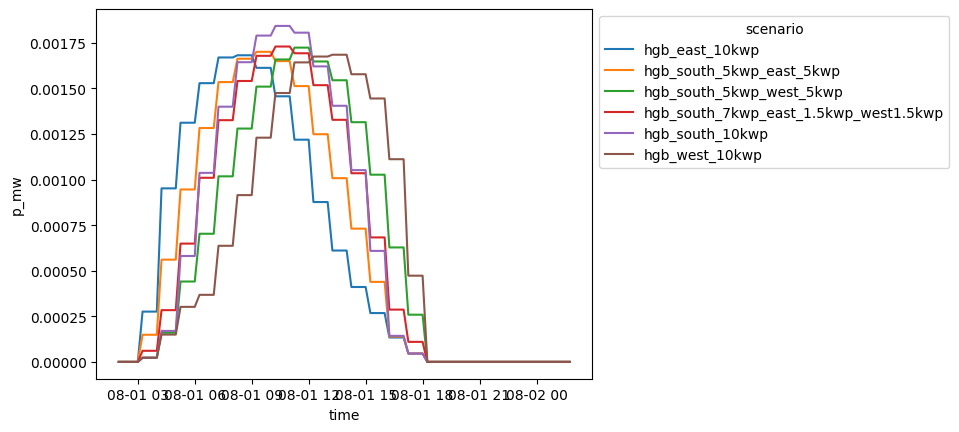

In [67]:
ax = sns.lineplot(data=sum_gen_ts, x='time', y='p_mw', hue='scenario')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

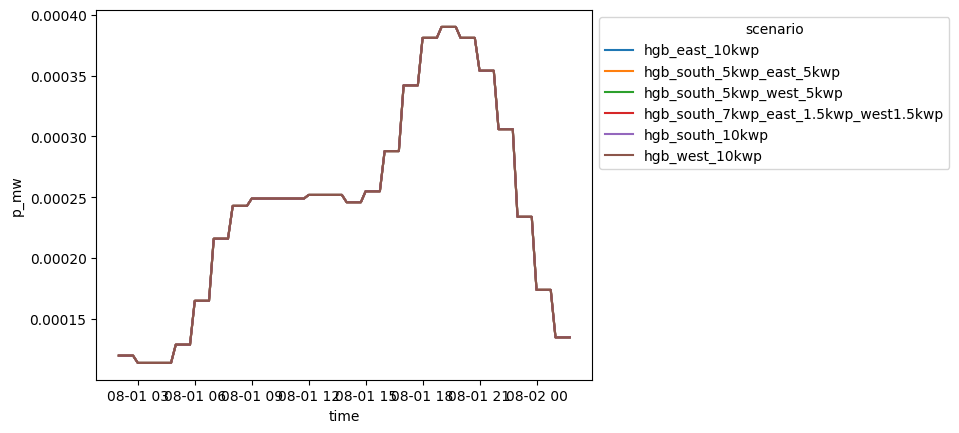

In [68]:
ax = sns.lineplot(data=sum_load_ts, x='time', y='p_mw', hue='scenario')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

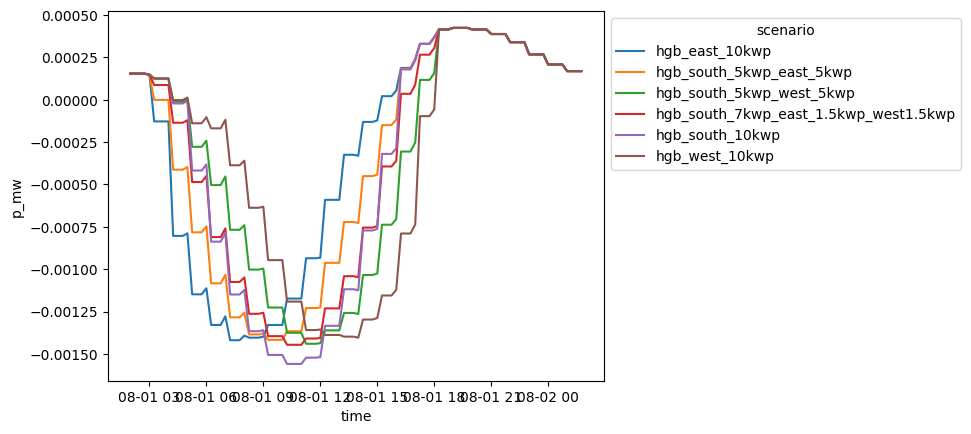

In [69]:
ax = sns.lineplot(data=sum_grid_ts, x='time', y='p_mw', hue='scenario')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [103]:
sum_grid_get_from_grid = sum_grid_ts[sum_grid_ts['p_mw'] > 0][['p_mw', 'scenario']].groupby('scenario').sum()
sum_grid_push_to_grid = sum_grid_ts[sum_grid_ts['p_mw'] < 0][['p_mw', 'scenario']].groupby('scenario').sum()
sum_grid_scenario = sum_grid_ts[['p_mw', 'scenario']].groupby('scenario').sum()
sum_generation = sum_gen_ts[['p_mw', 'scenario']].groupby('scenario').sum()

# data = { 'from_grid': sum_grid_get_from_grid.values, 'to_grid': sum_grid_push_to_grid.values, 'sum_grid': sum_grid_scenario.values, 'generation': sum_generation.values}
# #scenario_df = pd.DataFrame(data=data, index = sum_grid_get_from_grid.index)
# data

scenario_df = sum_grid_get_from_grid.merge(sum_generation, on='scenario', suffixes=('_from_grid', '_generation'))
#scenario_df = scenario_df.merge(sum_generation, on='scenario')
scenario_df

,p_mw_from_grid,p_mw_generation
scenario,,
hgb_east_10kwp,0.013165,0.056228
hgb_south_10kwp,0.013512,0.060680
hgb_south_5kwp_east_5kwp,0.013026,0.058452
hgb_south_5kwp_west_5kwp,0.011891,0.059760
hgb_south_7kwp_east_1.5kwp_west1.5kwp,0.012528,0.059736
hgb_west_10kwp,0.011392,0.058844


In [109]:
scenario_df = scenario_df.rename(columns={'p_mw': 'p_mw_gen'})
scenario_df = scenario_df.reset_index()
scenario_df

,index,scenario,p_mw_from_grid,p_mw_generation
0,0,hgb_east_10kwp,0.013165,0.056228
1,1,hgb_south_10kwp,0.013512,0.060680
2,2,hgb_south_5kwp_east_5kwp,0.013026,0.058452
3,3,hgb_south_5kwp_west_5kwp,0.011891,0.059760
4,4,hgb_south_7kwp_east_1.5kwp_west1.5kwp,0.012528,0.059736
5,5,hgb_west_10kwp,0.011392,0.058844


In [125]:
fig_grid_consumption_overall_production = go.Figure()
#test.add_trace(go.Scatter(x=scenario_df['p_mw_generation'], y=scenario_df['p_mw_from_grid'], mode='markers', name="a"))
for scenario in scenarios:
    df = scenario_df[scenario_df['scenario'] == scenario]
    fig_grid_consumption_overall_production.add_trace(go.Scatter(x=df['p_mw_generation'], y=df['p_mw_from_grid'],
                                                                mode='markers',
                                                                name=scenario))
fig_grid_consumption_overall_production.show()

TypeError: `obj` must be a seaborn Grid or matplotlib Axes or Figure instance.

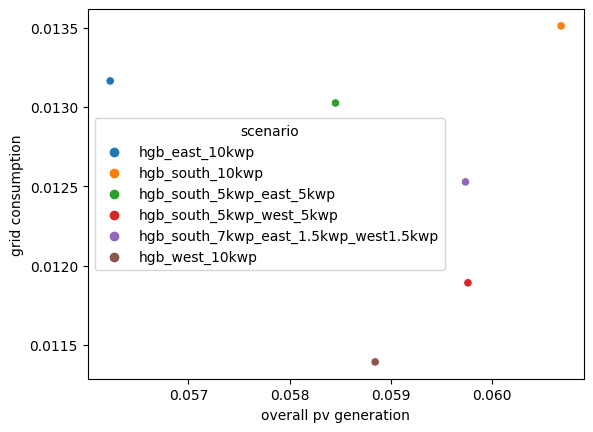

In [117]:
ax = sns.scatterplot(data=scenario_df, x='p_mw_generation', y='p_mw_from_grid', hue='scenario')
ax = ax.set(xlabel="overall pv generation", ylabel="grid consumption")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [84]:
sum_grid_push_to_grid = sum_grid_ts[sum_grid_ts['p_mw'] < 0][['p_mw', 'scenario']].groupby('scenario').sum()
sum_grid_push_to_grid

,p_mw
scenario,
hgb_east_10kwp,-0.042725
hgb_south_10kwp,-0.047524
hgb_south_5kwp_east_5kwp,-0.044810
hgb_south_5kwp_west_5kwp,-0.044983
hgb_south_7kwp_east_1.5kwp_west1.5kwp,-0.045596
hgb_west_10kwp,-0.043568


In [86]:
sum_grid_scenario = sum_grid_ts[['p_mw', 'scenario']].groupby('scenario').sum()
#sum_grid_scenario
sum_grid_scenario.index

Index(['hgb_east_10kwp', 'hgb_south_10kwp', 'hgb_south_5kwp_east_5kwp',
       'hgb_south_5kwp_west_5kwp', 'hgb_south_7kwp_east_1.5kwp_west1.5kwp',
       'hgb_west_10kwp'],
      dtype='object', name='scenario')

In [76]:
sum_generation = sum_gen_ts[['p_mw', 'scenario']].groupby('scenario').sum()
sum_generation

,p_mw
scenario,
hgb_east_10kwp,0.056228
hgb_south_10kwp,0.060680
hgb_south_5kwp_east_5kwp,0.058452
hgb_south_5kwp_west_5kwp,0.059760
hgb_south_7kwp_east_1.5kwp_west1.5kwp,0.059736
hgb_west_10kwp,0.058844


In [79]:
sum_load = sum_load_ts[['p_mw', 'scenario']].groupby('scenario').sum()
sum_load

,p_mw
scenario,
hgb_east_10kwp,0.023352
hgb_south_10kwp,0.023352
hgb_south_5kwp_east_5kwp,0.023352
hgb_south_5kwp_west_5kwp,0.023352
hgb_south_7kwp_east_1.5kwp_west1.5kwp,0.023352
hgb_west_10kwp,0.023352
